In [140]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import qr
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import VQR
from qiskit_machine_learning.utils.loss_functions import SVCLoss, L1Loss

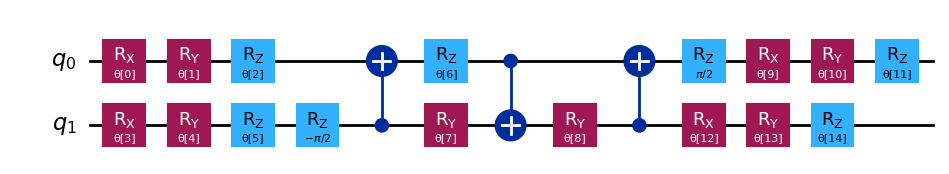

In [141]:
# We now define a two qubit unitary as defined in [3]

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rx(params[0], 0)
    target.ry(params[1], 0)
    target.rz(params[2], 0)
    target.rx(params[3], 1)
    target.ry(params[4], 1)
    target.rz(params[5], 1)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[6], 0)
    target.ry(params[7], 1)
    target.cx(0, 1)
    target.ry(params[8], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    target.rx(params[9], 0)
    target.ry(params[10], 0)
    target.rz(params[11], 0)
    target.rx(params[12], 1)
    target.ry(params[13], 1)
    target.rz(params[14], 1)
    return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=15)
circuit = conv_circuit(params)
circuit.draw("mpl")

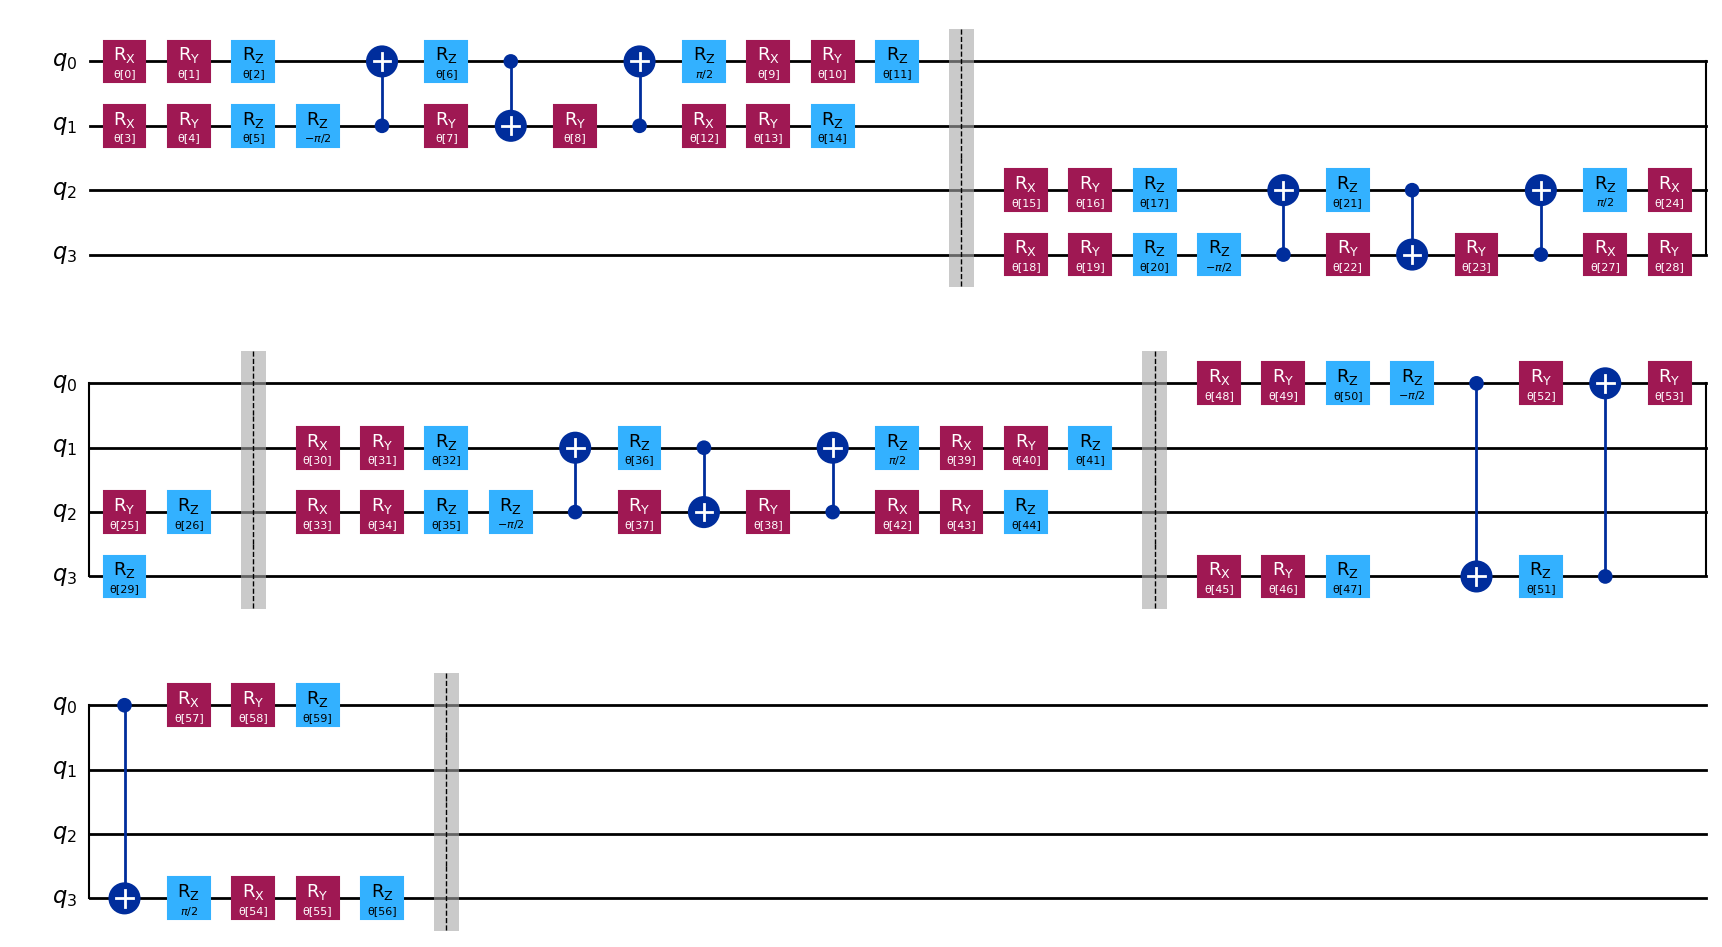

In [142]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

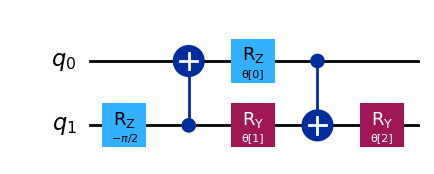

In [143]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

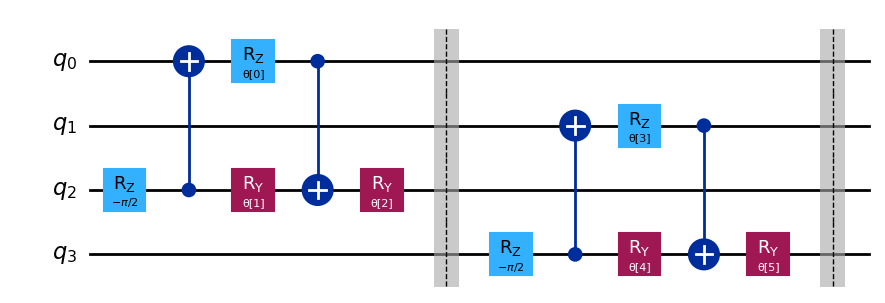

In [144]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [145]:
import tensorflow as tf
import collections
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [146]:
def filter_3649(x, y):
    keep = (y == 0) | (y == 1)| (y == 2) | (y == 3)
    x, y = x[keep], y[keep]
    # y = y == 3
    return x,y

In [147]:
x_train, y_train = filter_3649(x_train, y_train)
x_test, y_test = filter_3649(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 24754
Number of filtered test examples: 4157


0


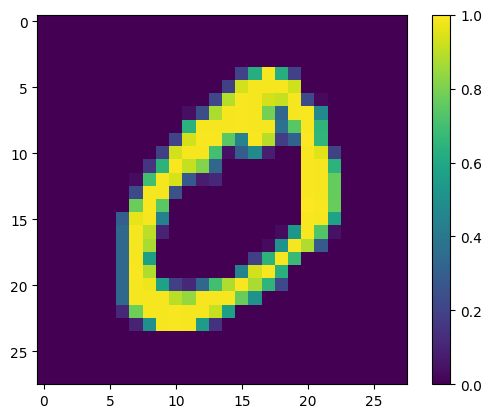

In [148]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [149]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

2


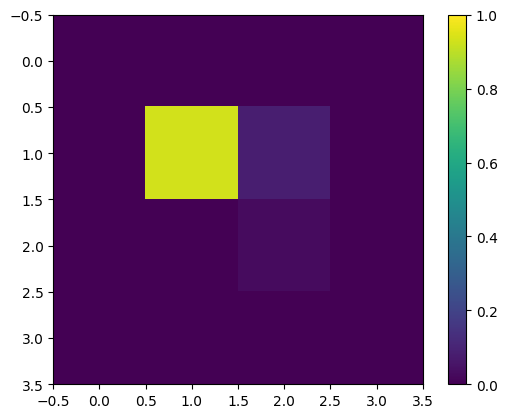

In [150]:
print(y_train[9])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [151]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and 1 in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and 2 in value)
    num_uniq_4 = sum(1 for value in mapping.values() if len(value) == 1 and 4 in value)
    num_uniq_9 = sum(1 for value in mapping.values() if len(value) == 1 and 9 in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) >= 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 1s: ", num_uniq_3)
    print("Number of unique 2s: ", num_uniq_6)
    print("Number of unique 4s: ", num_uniq_4)
    print("Number of unique 9s: ", num_uniq_9)
    print("Number of unique contradicting labels: ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.asarray(new_x), np.asarray(new_y)

In [152]:
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 16520
Number of unique 1s:  1720
Number of unique 2s:  4865
Number of unique 4s:  0
Number of unique 9s:  0
Number of unique contradicting labels:  694

Initial number of images:  24754
Remaining non-contradicting unique images:  15826
Number of unique images: 3102
Number of unique 1s:  420
Number of unique 2s:  905
Number of unique 4s:  0
Number of unique 9s:  0
Number of unique contradicting labels:  100

Initial number of images:  4157
Remaining non-contradicting unique images:  3002


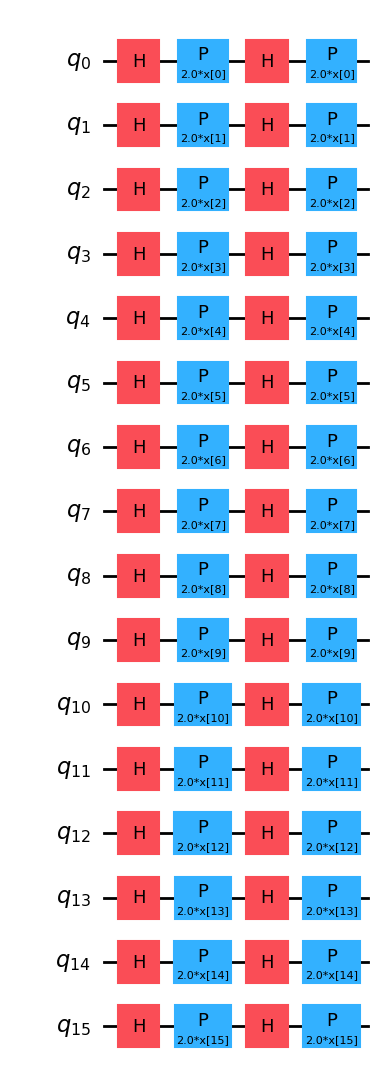

In [153]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

In [154]:
feature_map = ZFeatureMap(16)
ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# # Fourth Convolutional Layer
# ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# # Fourth Pooling Layer
# ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

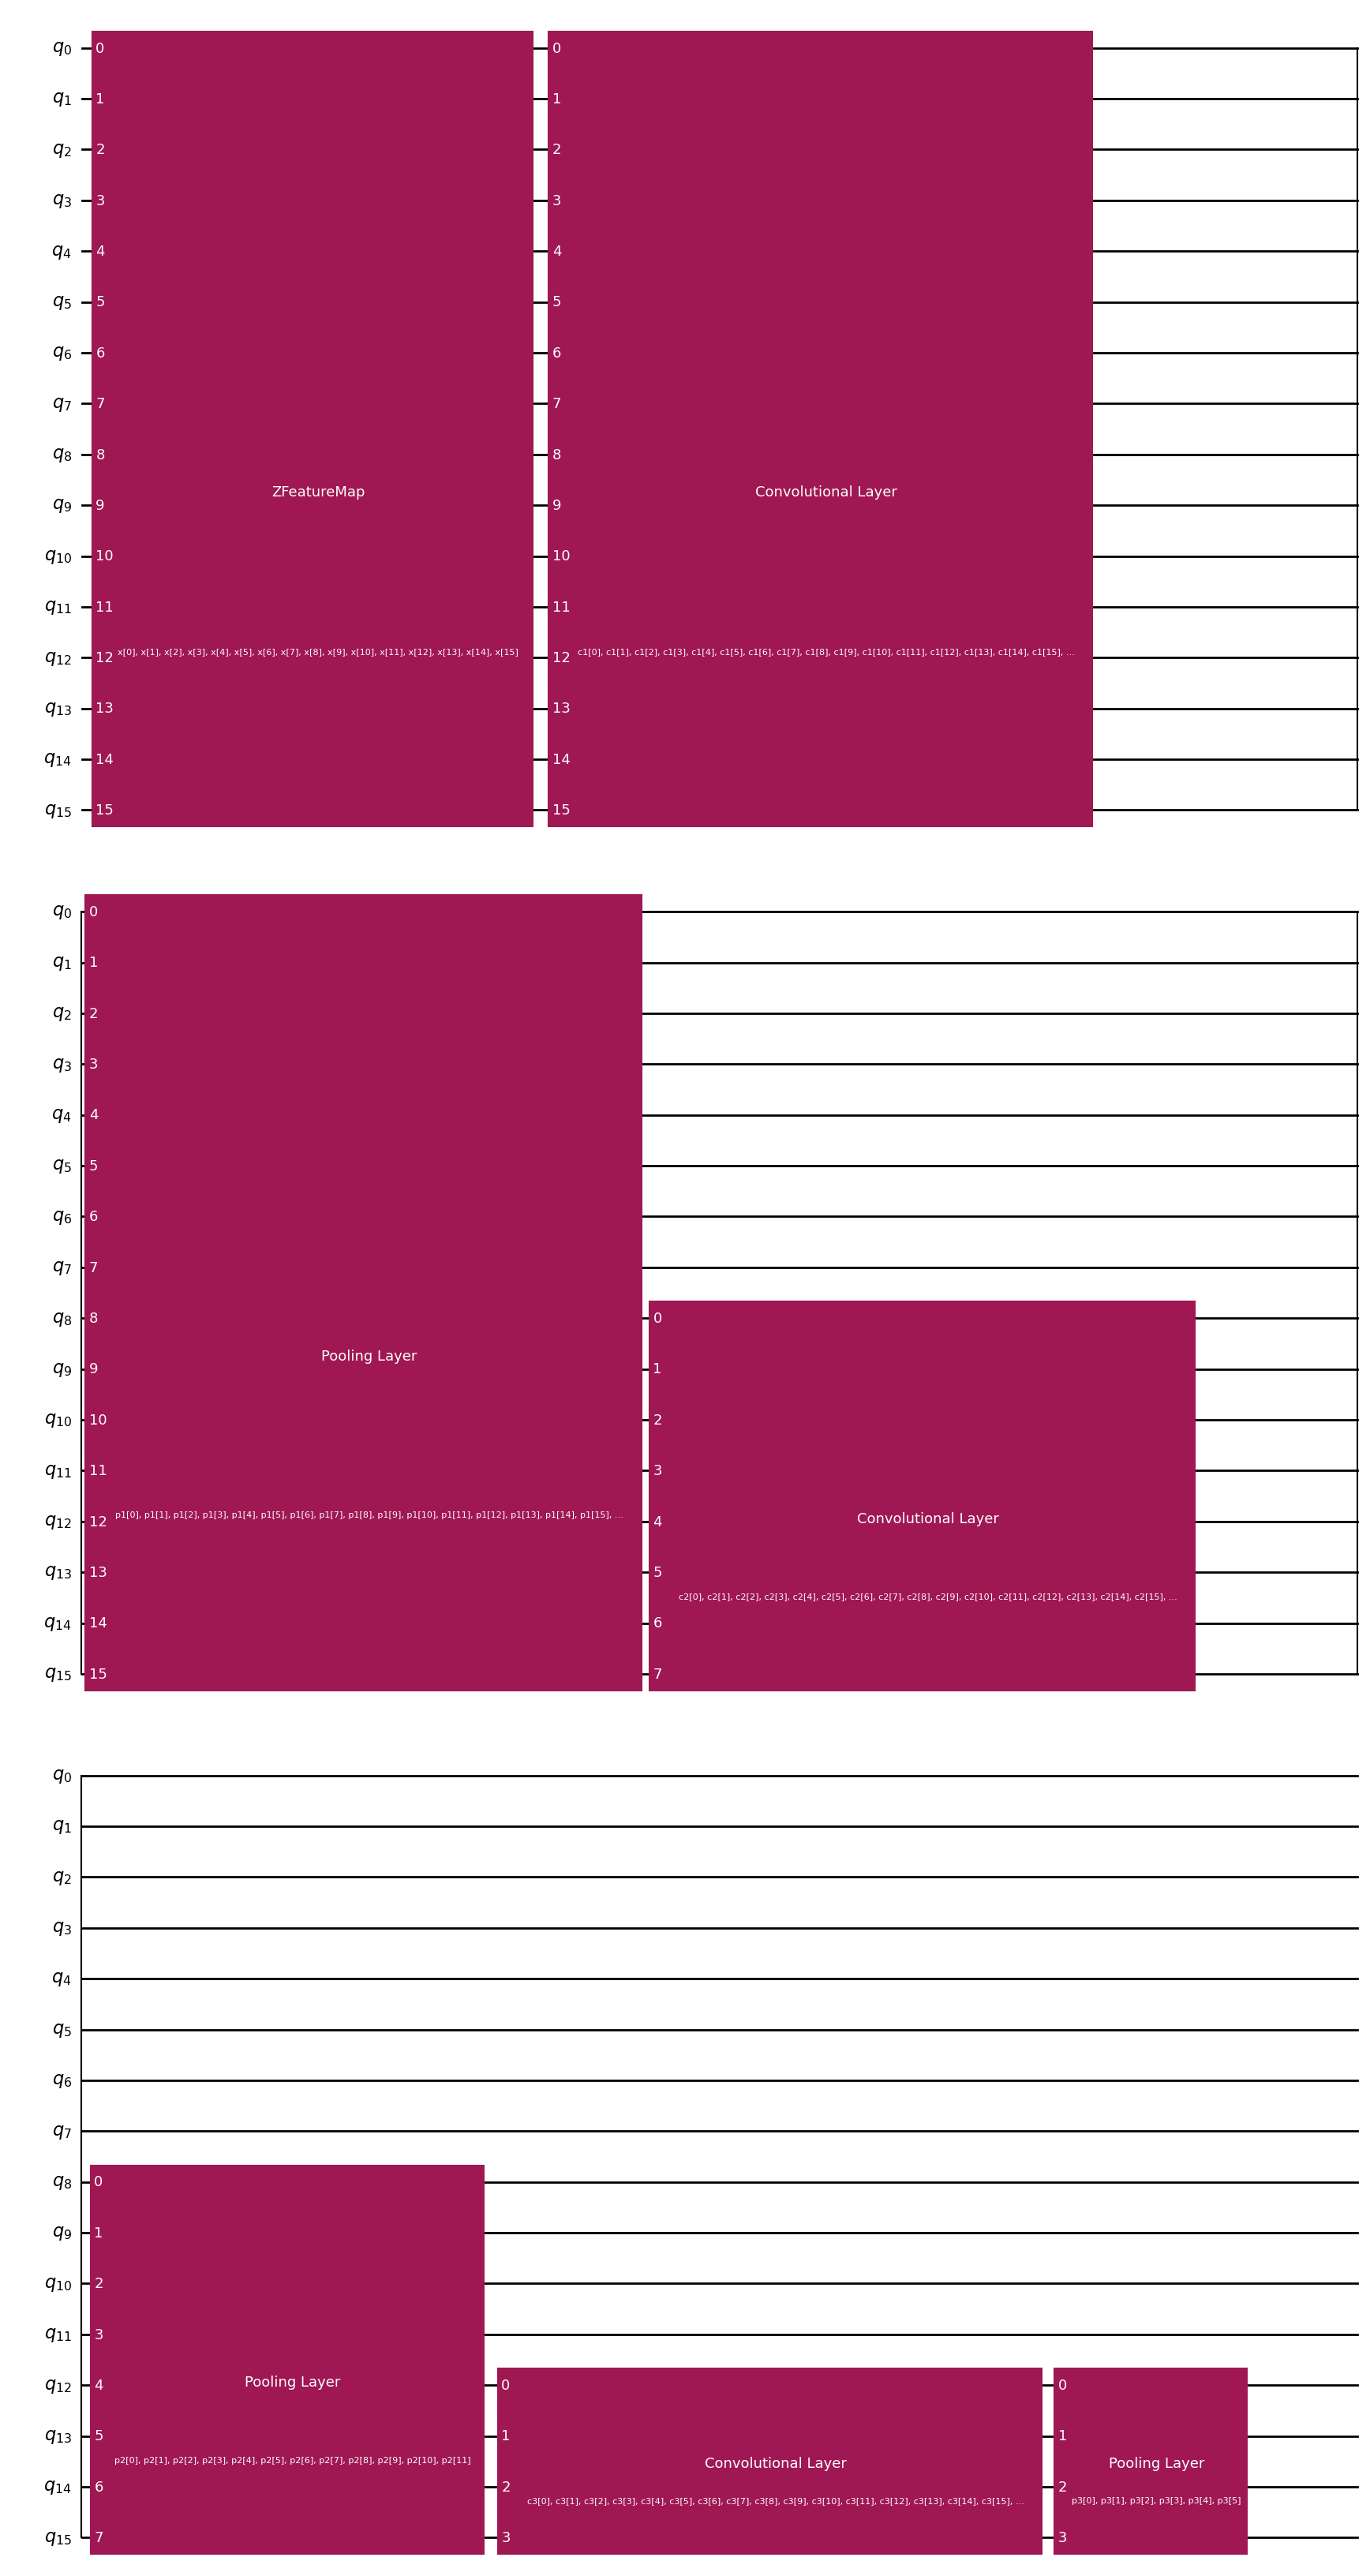

In [155]:
circuit.draw("mpl")

In [156]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    
  
    print("weights", weights)
    print("objective function value", objective_func_vals)
    
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [157]:
# construct variational quantum classifier
# weights = [2.08713408e+01,9.69442426e-01,2.06494753e+01,2.03016238e+01
# ,8.38673732e-01,5.91347668e-01,8.68356525e-01,2.05726074e+01
# ,5.35566810e-01,2.72472593e-02,7.66485468e-01,7.69303742e-01
# ,1.15558349e-01,5.60979716e-01,7.70304514e-01,5.10305683e-01
# ,1.81970714e-01,9.96455077e-02,9.03654103e-01,7.13858530e-01
# ,3.81401593e-01,2.24001140e-01,3.17102724e-01,3.68597993e-01
# ,4.79552292e-01,1.28201698e-01,8.86695711e-01,6.98318152e-01
# ,8.10926111e-01,6.81025099e-01,4.05816270e-01,9.95904230e-03
# ,2.42555762e-02,7.06494904e-01,4.80815891e-01,9.08096550e-02
# ,1.83550847e-01,8.67463660e-01,7.89718793e-03,5.23676210e-01
# ,4.83620087e-01,1.42242154e-01,5.86965447e-01,3.46898045e-01
# ,1.72047730e-01,4.25815796e-01,4.47743980e-01,2.11385232e-01
# ,9.51586920e-01,3.25970366e-01,6.31133238e-02,6.94112841e-01
# ,3.42171169e-01,3.62972489e-01,1.65090763e-01,3.28341676e-01
# ,7.33638678e-01,3.57879283e-01,6.31370438e-01,8.26089957e-01
# ,7.16214502e-01,2.02936973e-01,5.23099165e-02,6.96915759e-01
# ,1.03508971e-01,6.06925412e-01,9.13982098e-02,1.14591331e-01
# ,2.52012917e-01,9.63696757e-01,4.19835306e-01,7.84639901e-01
# ,2.16006146e-01,2.30343637e-01,7.80622010e-01,9.49516422e-02
# ,3.92230113e-01,4.20016449e-01,4.74021934e-01,9.34243640e-01
# ,5.71833171e-02,1.50290763e-01,5.25027831e-01,5.29635049e-01
# ,4.20129599e-02,7.04146275e-01,6.49464383e-01,4.40471533e-01
# ,9.34868406e-02,8.47444906e-01,7.22613442e-01,6.90302526e-01
# ,7.52876130e-01,4.13134986e-02,4.77260120e-01,4.80581957e-01
# ,8.38911532e-01,6.48595940e-01,3.20456449e-01,6.45069288e-01
# ,3.38224545e-01,1.38119904e-01,3.53391372e-01,9.15791753e-02
# ,5.01141220e-01,5.09925867e-01,1.78963246e-01,8.97796373e-04
# ,6.99780082e-01,9.58105505e-01,7.61130600e-01,8.07363210e-02
# ,7.10834150e-01,3.68351482e-01,9.84709644e-01,9.21112268e-01
# ,8.44173091e-01,5.10679238e-01,6.94451057e-01,9.95754243e-01
# ,5.87682096e-01,8.74509153e-02,8.08771701e-01,6.54169132e-01
# ,9.10006472e-01,9.91258031e-01,2.63844356e-01,7.25236642e-03
# ,9.73872415e-01,2.19216492e-01,4.39770067e-01,7.81124781e-01
# ,1.25632165e-02,8.90434434e-01,8.90459239e-01,1.16424251e-01
# ,1.93670640e-01,3.74420901e-02,4.05237140e-01,3.30965051e-01
# ,5.54630748e-01,7.45286743e-01,4.37644940e-01,5.60380363e-01
# ,8.02178042e-01,3.34418168e-01,5.16413468e-01,1.19311625e-01
# ,1.78721235e-01,3.23156385e-01,7.74644336e-01,8.37013082e-01
# ,3.26678850e-01,3.61256099e-01,9.39704066e-01,5.57896919e-01
# ,5.77430956e-01,5.31225879e-01,4.24296499e-01,6.63552061e-01
# ,3.91647619e-01,1.87661753e-01,8.73535645e-03,7.65984431e-01
# ,7.14672605e-01,3.67435649e-01,6.58672998e-01,2.89352220e-01
# ,4.81398548e-01,9.66381311e-01,1.00523226e-01,2.79559888e-01
# ,9.00965751e-01,7.31045429e-01,6.47540285e-01,6.21504597e-01
# ,3.57847851e-01,7.86833666e-01,5.55043134e-01,2.56974676e-02
# ,2.91987249e-01,5.08576789e-01,5.01472890e-02,8.02315181e-01
# ,1.37218959e-01,9.75406777e-01,6.99186841e-01,1.73631908e-01
# ,4.77033043e-01,2.43269621e-01,9.78989285e-01,9.11104163e-01
# ,5.40078158e-01,1.75171507e-02,2.56138084e-01,6.83087751e-01
# ,8.07849767e-01,4.51961656e-01,8.06717619e-02,9.16042019e-01
# ,2.82928451e-01,4.86740529e-01,4.16291246e-01,1.78671802e-01
# ,3.04981607e-01,1.38797397e-01,8.73225448e-01,8.69136195e-01
# ,3.61594546e-01,9.80698234e-01,4.61686324e-01,6.14086844e-01
# ,6.79519619e-01,1.77819586e-01,6.26772594e-02,2.55353927e-01
# ,3.10111974e-01,3.60341134e-01,9.28054467e-01,8.36517523e-01
# ,3.17231084e-01,2.24897328e-01,1.42884813e-01,9.64642142e-01
# ,7.99896899e-01,3.23919578e-01,2.50822312e-01,6.98822209e-01
# ,7.05892439e-01,5.61837822e-01,4.85767691e-02,2.57543880e-01
# ,3.77909365e-01,7.38248335e-01,7.49530751e-01,6.57926250e-01
# ,9.15088151e-01,7.61467726e-01,5.46076142e-01,3.92912526e-01
# ,8.81942382e-01,6.68322270e-01,9.57136440e-01,3.79161198e-01
# ,4.40675647e-01,6.84309872e-01,8.62593385e-01,2.15752638e-01
# ,8.43722397e-01,9.38086084e-01,3.84613185e-02,6.47350318e-01
# ,7.90091858e-02,2.76987651e-01,6.39618155e-01,8.65124052e-01
# ,3.60785497e-01,5.13444918e-01,7.98050076e-01,7.50598825e-01
# ,9.12018522e-01,1.38627060e-01,8.81285639e-01,4.97857438e-01
# ,8.75855734e-01,6.91811106e-01,3.74970997e-01,9.16085809e-01
# ,2.85619691e-03,2.68728916e-01,4.76075361e-01,1.09152718e-01
# ,2.81789874e-02,4.21123727e-01,6.82529104e-01,4.05563484e-01
# ,5.50159528e-01,2.02122291e-01,9.97297549e-01,8.00891323e-01
# ,4.98946907e-01,9.74772983e-01,2.34917028e-01,5.54115388e-01
# ,2.07241859e-01,1.43033542e-01,1.72808933e-02,6.17434296e-01
# ,7.59083807e-01,5.03761433e-01,7.46247999e-01,2.00243851e-01
# ,9.43347527e-01,9.28844994e-01,1.42821649e-01,3.70438765e-01
# ,3.49062725e-01,2.51276380e-01,7.59617383e-01,3.05026555e-01
# ,9.96064529e-01,6.18375778e-01,5.18180457e-01,4.52564100e-01
# ,2.00089869e-01,6.73638371e-01,9.51113027e-01,3.14038825e-02
# ,4.45942891e-01,3.33918708e-02,7.40978875e-01,8.30967522e-01
# ,5.77130038e-01,6.72672674e-01,6.91033306e-01,6.07881490e-01
# ,3.67029300e-01,1.59710505e-01,8.48123335e-01,3.28286297e-01
# ,2.84725716e-01,2.34602001e-01,9.09859613e-01,5.01405009e-01
# ,8.39723055e-01,9.22705418e-01,9.60365446e-01,5.34967716e-02
# ,8.15947352e-01,2.47514091e-01,1.33299185e-01,3.16078371e-01
# ,2.57508001e-01,2.50103278e-01,2.28674113e-01,9.47266122e-01
# ,5.44529659e-03,7.27462191e-02,7.58036423e-01,4.19363722e-01
# ,9.54189807e-01,7.38777602e-01,9.49965020e-01,8.10222371e-01
# ,1.55912098e-01,7.12503905e-01,5.72203034e-01,4.70545476e-01
# ,1.92905552e-01,6.88174576e-01,7.58153500e-01,3.32931259e-01
# ,9.84761551e-01,3.25488480e-01,5.22895788e-01,3.37964919e-01
# ,9.84300807e-01,8.57248380e-01,9.74974804e-01,6.91021186e-01
# ,1.92831910e-01,7.39133913e-01,9.00494299e-01,8.50129523e-01
# ,6.48058260e-01,1.33772620e-04,8.69139920e-02,8.46603814e-01
# ,3.35244934e-01,1.85411447e-01,7.24326059e-01,3.47432774e-01
# ,5.34843684e-01,8.37033143e-01,3.49542294e-02,8.87437767e-01
# ,4.64174541e-01,4.97221885e-01,3.21066069e-01,7.90087499e-01
# ,6.74595788e-01,2.59478081e-01,7.51526880e-01,3.63451601e-01
# ,6.49644416e-01,9.60521249e-01,2.19017712e-01,5.95295109e-01
# ,3.36060224e-02,8.26454717e-01,3.99218686e-01,9.39882170e-01
# ,6.54553089e-01,6.73250871e-01,4.35344987e-01,1.88248993e-01
# ,9.63136087e-01,6.98458604e-01,7.65282962e-01,7.19175495e-01
# ,5.25149220e-03,3.93093538e-01,8.72593878e-01,2.02609567e-01
# ,6.32053801e-01,8.64070390e-01,2.49399442e-01,3.23712003e-01
# ,4.67087188e-01,8.44994375e-01,4.41094843e-01,7.44869508e-01
# ,5.33812868e-01,9.99731100e-01,9.45560767e-04,2.40194135e-01
# ,1.89224052e-01,5.49054315e-01,5.80672233e-01,9.04104486e-01
# ,5.07660233e-02,7.03670415e-01,4.11233999e-01,3.35837327e-01
# ,4.98207364e-01,7.86211668e-01,3.44479865e-01,2.48312946e-01
# ,3.00853957e-01,4.83822573e-01,2.16648071e-01,2.54558214e-01
# ,3.12703441e-01,5.23181939e-01,1.64847494e-01,8.12032676e-02
# ,6.17284116e-01,9.85046161e-02,7.15370638e-01,3.82451567e-02
# ,4.92825673e-01,3.66900409e-01,8.64758398e-01,8.92942423e-01
# ,5.98076267e-01,8.06652254e-01,8.75995961e-01,5.73681128e-01
# ,6.93731027e-01,2.51785502e-01,2.81921425e-01,4.78721347e-01
# ,7.05155281e-01,5.25420454e-01,5.32660289e-01,4.89443330e-01
# ,6.39395951e-01,9.65172816e-01,9.18913432e-02,2.64503706e-01
# ,8.62304943e-01,5.77180018e-01]

weights = [2.06713408e+01,7.69442426e-01,2.08494753e+01,2.01016238e+01
,6.38673732e-01,3.91347668e-01,6.68356525e-01,2.03726074e+01
,7.35566810e-01,-1.72752741e-01,9.66485468e-01,5.69303742e-01
,-8.44416510e-02,3.60979716e-01,9.70304514e-01,3.10305683e-01
,3.81970714e-01,-1.00354492e-01,1.10365410e+00,9.13858530e-01
,1.81401593e-01,4.24001140e-01,5.17102724e-01,5.68597993e-01
,2.79552292e-01,3.28201698e-01,1.08669571e+00,4.98318152e-01
,6.10926111e-01,4.81025099e-01,6.05816270e-01,2.09959042e-01
,2.24255576e-01,5.06494904e-01,2.80815891e-01,-1.09190345e-01
,-1.64491530e-02,6.67463660e-01,2.07897188e-01,7.23676210e-01
,2.83620087e-01,3.42242154e-01,7.86965447e-01,5.46898045e-01
,3.72047730e-01,2.25815796e-01,2.47743980e-01,4.11385232e-01
,1.15158692e+00,1.25970366e-01,-1.36886676e-01,4.94112841e-01
,5.42171169e-01,5.62972489e-01,3.65090763e-01,1.28341676e-01
,5.33638678e-01,5.57879283e-01,8.31370438e-01,6.26089957e-01
,9.16214502e-01,4.02936973e-01,2.52309917e-01,8.96915759e-01
,-9.64910290e-02,8.06925412e-01,-1.08601790e-01,-8.54086690e-02
,4.52012917e-01,1.16369676e+00,6.19835306e-01,9.84639901e-01
,1.60061460e-02,4.30343637e-01,9.80622010e-01,2.94951642e-01
,5.92230113e-01,6.20016449e-01,2.74021934e-01,1.13424364e+00
,2.57183317e-01,3.50290763e-01,3.25027831e-01,3.29635049e-01
,-1.57987040e-01,5.04146275e-01,8.49464383e-01,6.40471533e-01
,-1.06513159e-01,1.04744491e+00,5.22613442e-01,8.90302526e-01
,9.52876130e-01,2.41313499e-01,2.77260120e-01,2.80581957e-01
,6.38911532e-01,4.48595940e-01,1.20456449e-01,4.45069288e-01
,1.38224545e-01,-6.18800960e-02,1.53391372e-01,2.91579175e-01
,7.01141220e-01,7.09925867e-01,3.78963246e-01,2.00897796e-01
,8.99780082e-01,1.15810550e+00,5.61130600e-01,2.80736321e-01
,9.10834150e-01,1.68351482e-01,1.18470964e+00,1.12111227e+00
,1.04417309e+00,7.10679238e-01,4.94451057e-01,7.95754243e-01
,3.87682096e-01,2.87450915e-01,6.08771701e-01,8.54169132e-01
,7.10006472e-01,1.19125803e+00,6.38443560e-02,2.07252366e-01
,7.73872415e-01,4.19216492e-01,6.39770067e-01,9.81124781e-01
,-1.87436784e-01,6.90434434e-01,1.09045924e+00,-8.35757490e-02
,3.93670640e-01,2.37442090e-01,2.05237140e-01,5.30965051e-01
,3.54630748e-01,9.45286743e-01,2.37644940e-01,7.60380363e-01
,1.00217804e+00,5.34418168e-01,7.16413468e-01,-8.06883750e-02
,-2.12787650e-02,5.23156385e-01,9.74644336e-01,6.37013082e-01
,1.26678850e-01,5.61256099e-01,7.39704066e-01,7.57896919e-01
,7.77430956e-01,7.31225879e-01,2.24296499e-01,4.63552061e-01
,5.91647619e-01,3.87661753e-01,2.08735356e-01,9.65984431e-01
,5.14672605e-01,1.67435649e-01,8.58672998e-01,8.93522200e-02
,2.81398548e-01,7.66381311e-01,-9.94767740e-02,4.79559888e-01
,1.10096575e+00,9.31045429e-01,8.47540285e-01,4.21504597e-01
,1.57847851e-01,5.86833666e-01,3.55043134e-01,2.25697468e-01
,9.19872490e-02,3.08576789e-01,2.50147289e-01,1.00231518e+00
,3.37218959e-01,7.75406777e-01,8.99186841e-01,3.73631908e-01
,6.77033043e-01,4.43269621e-01,1.17898929e+00,1.11110416e+00
,3.40078158e-01,2.17517151e-01,4.56138084e-01,8.83087751e-01
,1.00784977e+00,2.51961656e-01,-1.19328238e-01,1.11604202e+00
,8.29284510e-02,2.86740529e-01,2.16291246e-01,3.78671802e-01
,5.04981607e-01,-6.12026030e-02,6.73225448e-01,1.06913620e+00
,5.61594546e-01,1.18069823e+00,6.61686324e-01,4.14086844e-01
,8.79519619e-01,3.77819586e-01,2.62677259e-01,5.53539270e-02
,1.10111974e-01,1.60341134e-01,7.28054467e-01,6.36517523e-01
,5.17231084e-01,4.24897328e-01,3.42884813e-01,7.64642142e-01
,9.99896899e-01,1.23919578e-01,4.50822312e-01,8.98822209e-01
,5.05892439e-01,3.61837822e-01,2.48576769e-01,4.57543880e-01
,5.77909365e-01,9.38248335e-01,5.49530751e-01,8.57926250e-01
,7.15088151e-01,5.61467726e-01,7.46076142e-01,5.92912526e-01
,1.08194238e+00,8.68322270e-01,7.57136440e-01,1.79161198e-01
,6.40675647e-01,4.84309872e-01,6.62593385e-01,1.57526380e-02
,1.04372240e+00,1.13808608e+00,-1.61538682e-01,8.47350318e-01
,-1.20990814e-01,7.69876510e-02,8.39618155e-01,6.65124052e-01
,1.60785497e-01,7.13444918e-01,5.98050076e-01,5.50598825e-01
,1.11201852e+00,-6.13729400e-02,1.08128564e+00,6.97857438e-01
,6.75855734e-01,4.91811106e-01,5.74970997e-01,7.16085809e-01
,-1.97143803e-01,6.87289160e-02,6.76075361e-01,-9.08472820e-02
,2.28178987e-01,6.21123727e-01,4.82529104e-01,2.05563484e-01
,3.50159528e-01,2.12229100e-03,7.97297549e-01,1.00089132e+00
,2.98946907e-01,1.17477298e+00,4.34917028e-01,3.54115388e-01
,7.24185900e-03,3.43033542e-01,-1.82719107e-01,8.17434296e-01
,5.59083807e-01,3.03761433e-01,9.46247999e-01,2.43851000e-04
,7.43347527e-01,1.12884499e+00,-5.71783510e-02,5.70438765e-01
,1.49062725e-01,5.12763800e-02,5.59617383e-01,1.05026555e-01
,1.19606453e+00,8.18375778e-01,3.18180457e-01,6.52564100e-01
,4.00089869e-01,4.73638371e-01,1.15111303e+00,-1.68596118e-01
,2.45942891e-01,2.33391871e-01,5.40978875e-01,1.03096752e+00
,3.77130038e-01,8.72672674e-01,8.91033306e-01,8.07881490e-01
,1.67029300e-01,-4.02894950e-02,1.04812334e+00,5.28286297e-01
,8.47257160e-02,4.34602001e-01,7.09859613e-01,3.01405009e-01
,6.39723055e-01,1.12270542e+00,1.16036545e+00,2.53496772e-01
,1.01594735e+00,4.47514091e-01,3.33299185e-01,1.16078371e-01
,5.75080010e-02,5.01032780e-02,4.28674113e-01,1.14726612e+00
,2.05445297e-01,-1.27253781e-01,5.58036423e-01,6.19363722e-01
,1.15418981e+00,9.38777602e-01,7.49965020e-01,1.01022237e+00
,-4.40879020e-02,5.12503905e-01,7.72203034e-01,6.70545476e-01
,-7.09444800e-03,4.88174576e-01,5.58153500e-01,5.32931259e-01
,7.84761551e-01,5.25488480e-01,7.22895788e-01,1.37964919e-01
,1.18430081e+00,6.57248380e-01,7.74974804e-01,4.91021186e-01
,-7.16809000e-03,5.39133913e-01,1.10049430e+00,6.50129523e-01
,8.48058260e-01,-1.99866227e-01,2.86913992e-01,1.04660381e+00
,1.35244934e-01,3.85411447e-01,5.24326059e-01,1.47432774e-01
,3.34843684e-01,6.37033143e-01,-1.65045771e-01,6.87437767e-01
,6.64174541e-01,2.97221885e-01,1.21066069e-01,9.90087499e-01
,4.74595788e-01,5.94780810e-02,5.51526880e-01,1.63451601e-01
,4.49644416e-01,1.16052125e+00,1.90177120e-02,3.95295109e-01
,-1.66393978e-01,1.02645472e+00,1.99218686e-01,7.39882170e-01
,8.54553089e-01,8.73250871e-01,2.35344987e-01,-1.17510070e-02
,1.16313609e+00,4.98458604e-01,5.65282962e-01,9.19175495e-01
,-1.94748508e-01,5.93093538e-01,6.72593878e-01,4.02609567e-01
,4.32053801e-01,1.06407039e+00,4.49399442e-01,1.23712003e-01
,6.67087188e-01,6.44994375e-01,2.41094843e-01,9.44869508e-01
,3.33812868e-01,7.99731100e-01,2.00945561e-01,4.01941350e-02
,3.89224052e-01,7.49054315e-01,7.80672233e-01,1.10410449e+00
,-1.49233977e-01,9.03670415e-01,6.11233999e-01,1.35837327e-01
,2.98207364e-01,9.86211668e-01,1.44479865e-01,4.48312946e-01
,5.00853957e-01,2.83822573e-01,1.66480710e-02,4.54558214e-01
,1.12703441e-01,7.23181939e-01,3.64847494e-01,-1.18796732e-01
,4.17284116e-01,2.98504616e-01,9.15370638e-01,-1.61754843e-01
,2.92825673e-01,5.66900409e-01,1.06475840e+00,6.92942423e-01
,7.98076267e-01,1.00665225e+00,6.75995961e-01,7.73681128e-01
,8.93731027e-01,5.17855020e-02,8.19214250e-02,2.78721347e-01
,9.05155281e-01,7.25420454e-01,7.32660289e-01,6.89443330e-01
,4.39395951e-01,1.16517282e+00,-1.08108657e-01,4.64503706e-01
,1.06230494e+00,3.77180018e-01]
  
classifier = VQC(
    feature_map=feature_map.decompose(),
    ansatz=ansatz.decompose(),
    optimizer=COBYLA(maxiter=10),
    callback=callback_graph,
    # warm_start = True
    # initial_point = weights
)

In [158]:
# y_int = []
# for a in train_labels:
#     if a:
#         y_int.append(1)
#     else: 
#         y_int.append(-1)
        
# y1_int = []
# for a in test_labels:
#     if a:
#         y1_int.append(1)
#     else: 
#         y1_int.append(-1)

x_reshaped = []
x1_reshaped = []

for b in resized_train_images:
    x_reshaped.append(b.reshape(1,16))

for b in resized_test_images:
    x1_reshaped.append(b.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    #print("entry \n" , entry[0])
    final_x.append(entry[0])

for entry in x1_reshaped:
    #print("entry \n" , entry[0])
    final_x1.append(entry[0])

objective_func_vals = []

x = np.asarray(final_x)
y = np.asarray(train_labels)

x = x[:4]
y = y[:4]

print(x)
print(y)

# def convert_to_onehot(arr):
#     encoded_arr = np.zeros((arr.size, arr.max()+1), dtype=int)
#     encoded_arr[np.arange(arr.size),arr] = 1
#     print(encoded_arr)
# y = convert_to_onehot(y)

[[0.         0.         0.         0.         0.         0.93333334
  0.08235294 0.         0.         0.         0.02745098 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.99215686 0.         0.         0.1882353  0.         0.
  0.         0.99215686 0.         0.        ]
 [0.         0.         0.         0.         0.         0.9882353
  0.3019608  0.         0.         0.7058824  0.5058824  0.19215687
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.33333334 0.         0.         0.         0.9882353  0.
  0.         0.6745098  0.         0.        ]]
[0 1 2 3]


weights [1.91266567 1.43863545 0.93099133 0.64914585 0.23306411 0.9713758
 0.40059542 0.08797694 1.81311485 0.33793705 0.91904569 0.96346342
 0.03832623 0.6085557  0.68219866 0.77543011 0.35868662 0.26286619
 0.3182006  0.56343637 0.06095038 0.65847902 0.93415862 0.6472374
 0.03278836 0.75538754 0.37185141 0.07413731 0.0298575  0.82487939
 0.22562172 0.93345646 0.24681857 0.91922919 0.01616186 0.62982461
 0.23019825 0.89815368 0.67877443 0.39383063 0.94106324 0.40171077
 0.97426774 0.58053824 0.07236276 0.50262569 0.91826539 0.4335641
 0.21781553 0.18471502 0.06127339 0.54854539 0.46634837 0.98838463
 0.90378749 0.18988915 0.22437723 0.28636665 0.34278743 0.47420984
 0.55757767 0.40897917 0.9347391  0.26394916 0.34380488 0.37839719
 0.10280474 0.21367201 0.81669466 0.27658644 0.3647066  0.51797705
 0.07444613 0.89837631 0.83562045 0.36528436 0.52717756 0.65145246
 0.61622471 0.35351611 0.05748578 0.30541422 0.66731847 0.97924962
 0.61843875 0.17382125 0.74055741 0.84034923 0.07469009 0

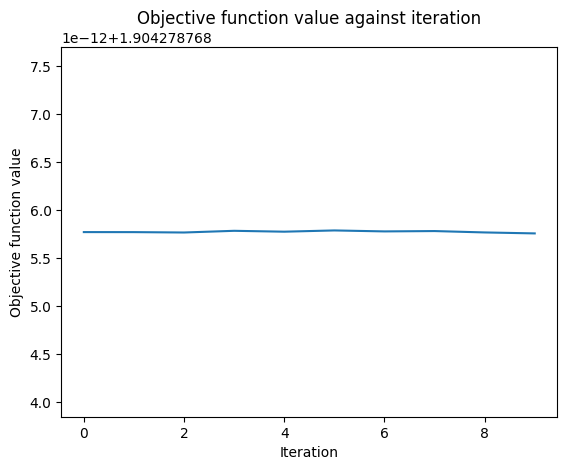

Accuracy from the train data : 25.0%


In [159]:
classifier.fit(x, y)
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [161]:
x1 = np.asarray(final_x1)
y1 = np.asarray(test_labels)
        
x1 = x1[:5]
y1 = y1[:5]
y_predict = classifier.predict(x1)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

Accuracy from the test data : 0.0%


In [162]:
y_predict


array([1, 2, 0, 1, 1], dtype=uint8)

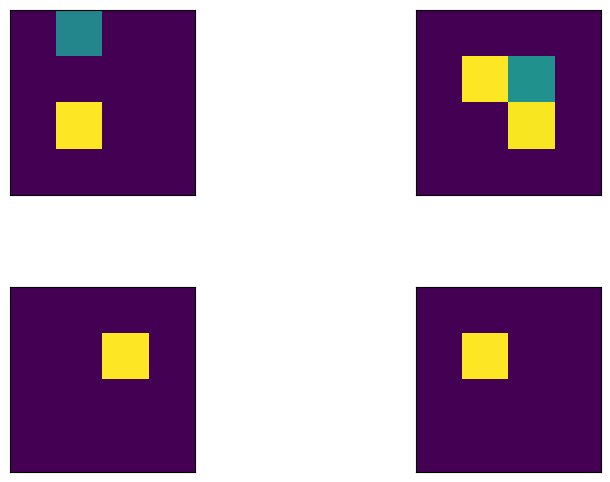

In [163]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 3:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if y_predict[i] == 6:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 6")
    if y_predict[i] == 4:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")   
    if y_predict[i] == 9:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 9") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)